In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from glob import glob

import pandas as pd
import plotnine as p

Populating the interactive namespace from numpy and matplotlib


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [27]:
img = plt.imread('Screenshots/2020-04-03 06_00_01-2020-03-29_SE_Mobility_Report_en.pdf.png')

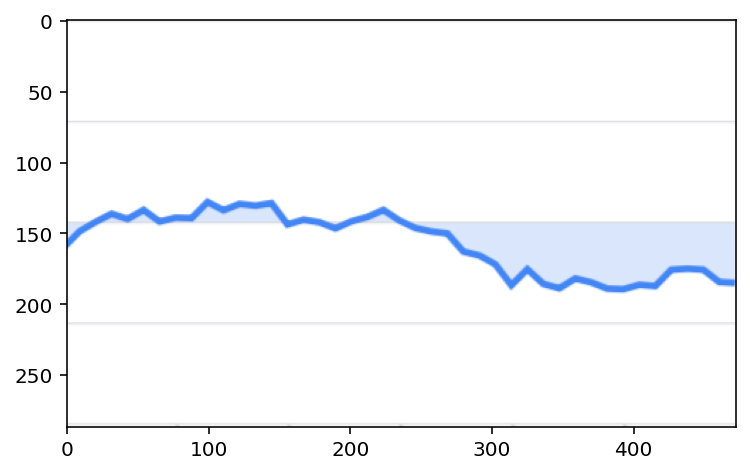

In [28]:
plt.imshow(img);

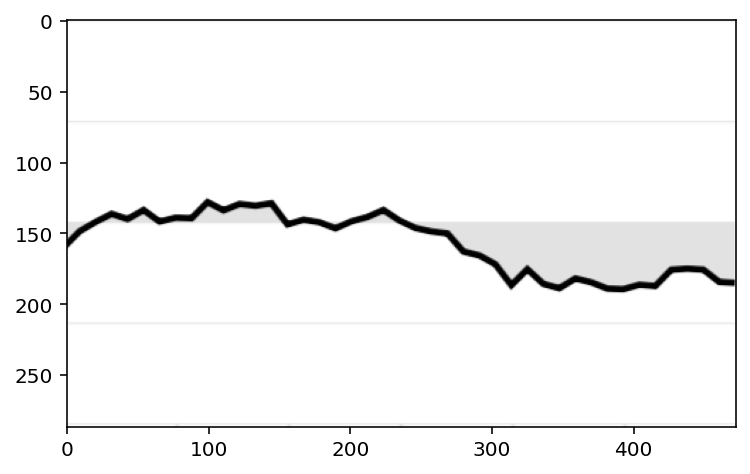

In [29]:
plt.imshow(img[:, :, 0], cmap=cm.Greys_r);

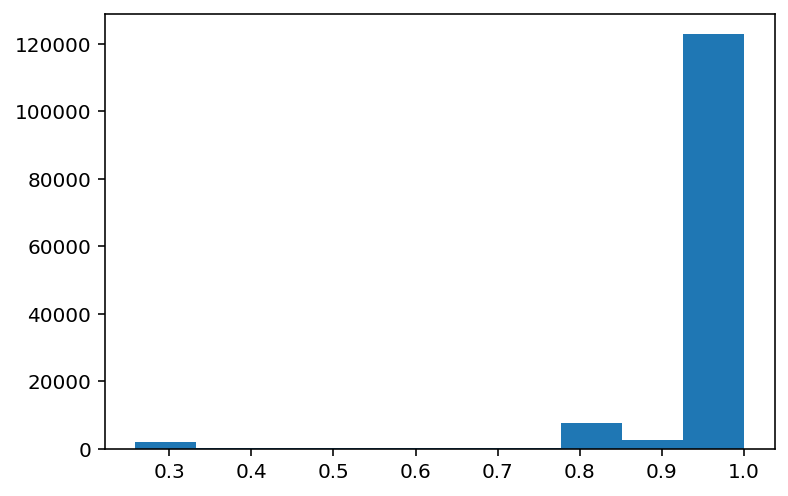

In [30]:
plt.hist(img[:, :, 0].flatten());

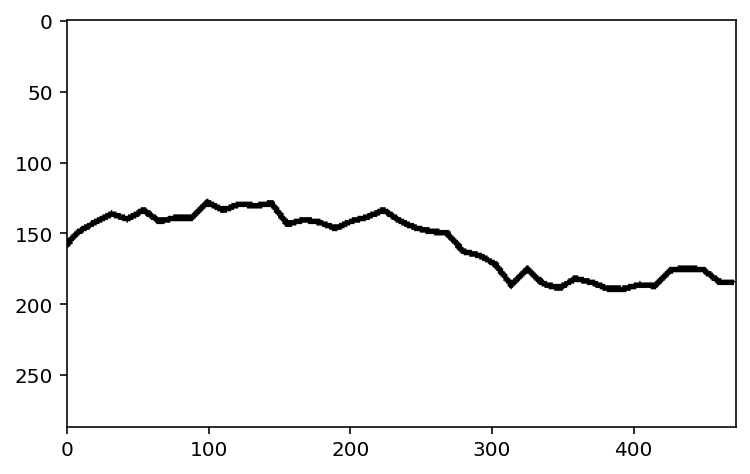

In [31]:
plt.imshow(0.5 < img[:, :, 0], cmap=cm.Greys_r);

In [32]:
# Binarize the image
mask = 0.5 < img[:, :, 0]

# The `.argmin(0)` method will return the first index where
# we see a black pixel along the y-axis in the image.
# Images have negative y-axis, flip to get positive values.
pixel_value = -mask.argmin(0)

# We know the y-axis spans the interval [-80, 80]. To get the
# original values, scale values to the fraction of vertical pixels
# the observed values are at. Then scale these fractions to the
# [-80, 80] interval.
percent = 160 * (pixel_value + img.shape[0]) / img.shape[0] - 80

In [33]:
# The reported dates start on February 16 and ends on March 29.
# Make a DateRangeIndex defined for a single day's resolution.
dates = pd.date_range(datetime.date(2020, 2, 16), datetime.date(2020, 3, 29))

In [34]:
daily_percent = (
    pd.DataFrame({
        # Use the `cut()` function to bin horizontal pixels into
        # intervals corresponding to the days.
        'bins': pd.cut(np.arange(percent.shape[0]), bins=dates.shape[0]),
        'percent': percent
    })
    # Group the percent values by the day bins.
    .groupby('bins')
    # Extract the median percent value for each bin.
    .median()
    .reset_index(drop=True)
)

# Finally, add the dates to the data
daily_percent['date'] = dates

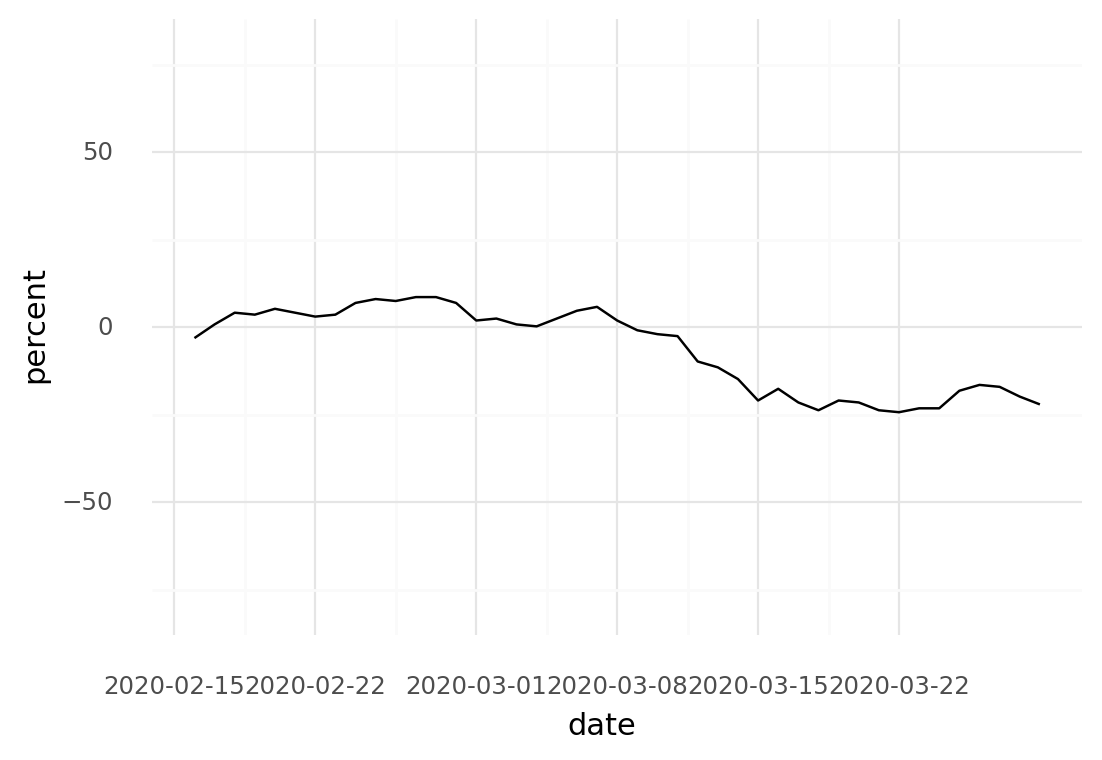

<ggplot: (-9223371871890584984)>

In [35]:
p.options.figure_size = (6, 4)
(
    p.ggplot(p.aes(x='date', y='percent'), daily_percent)
    + p.geom_line()
    + p.scale_y_continuous(limits=(-80, 80))
    + p.theme_minimal()
)

In [36]:
# Now perform the same thing for each of the screenshots.

dfs = []
for fname in glob('Screenshots/*.pdf.png'):
    # We can extract the country code from the file name.
    country = fname.split('_')[3]
    
    img = plt.imread(fname)
    
    mask = 0.5 < img[:, :, 0]
    pixel_value = -mask.argmin(0)
    percent = 160 * (pixel_value + img.shape[0]) / img.shape[0] - 80
    
    dates = pd.date_range(
        start=datetime.date(2020, 2, 16),
        end=datetime.date(2020, 3, 29)
    )
    
    daily_percent = (
        pd.DataFrame({
            'bins': pd.cut(
                np.arange(percent.shape[0]),
                bins=dates.shape[0]
            ),
            'percent_retail_and_recreation': percent
        })
        .groupby('bins')
        .median()
        .reset_index(drop=True)
    )

    daily_percent['date'] = dates
    
    mobility_df = (
        daily_percent
        .assign(country=country)
    )
    
    dfs.append(mobility_df)
    
mobility_df = pd.concat(dfs)

# Because of how the screenshots are made we cannot observe values
# below -80%; these will appear as 80% because how the `argmin()`
# method works. Instead we censor cases when percent goes below -80%
mobility_df['percent_retail_and_recreation'] = (
    mobility_df['percent_retail_and_recreation']
    .map(lambda i: {80.0: -80}.get(i, i))
)

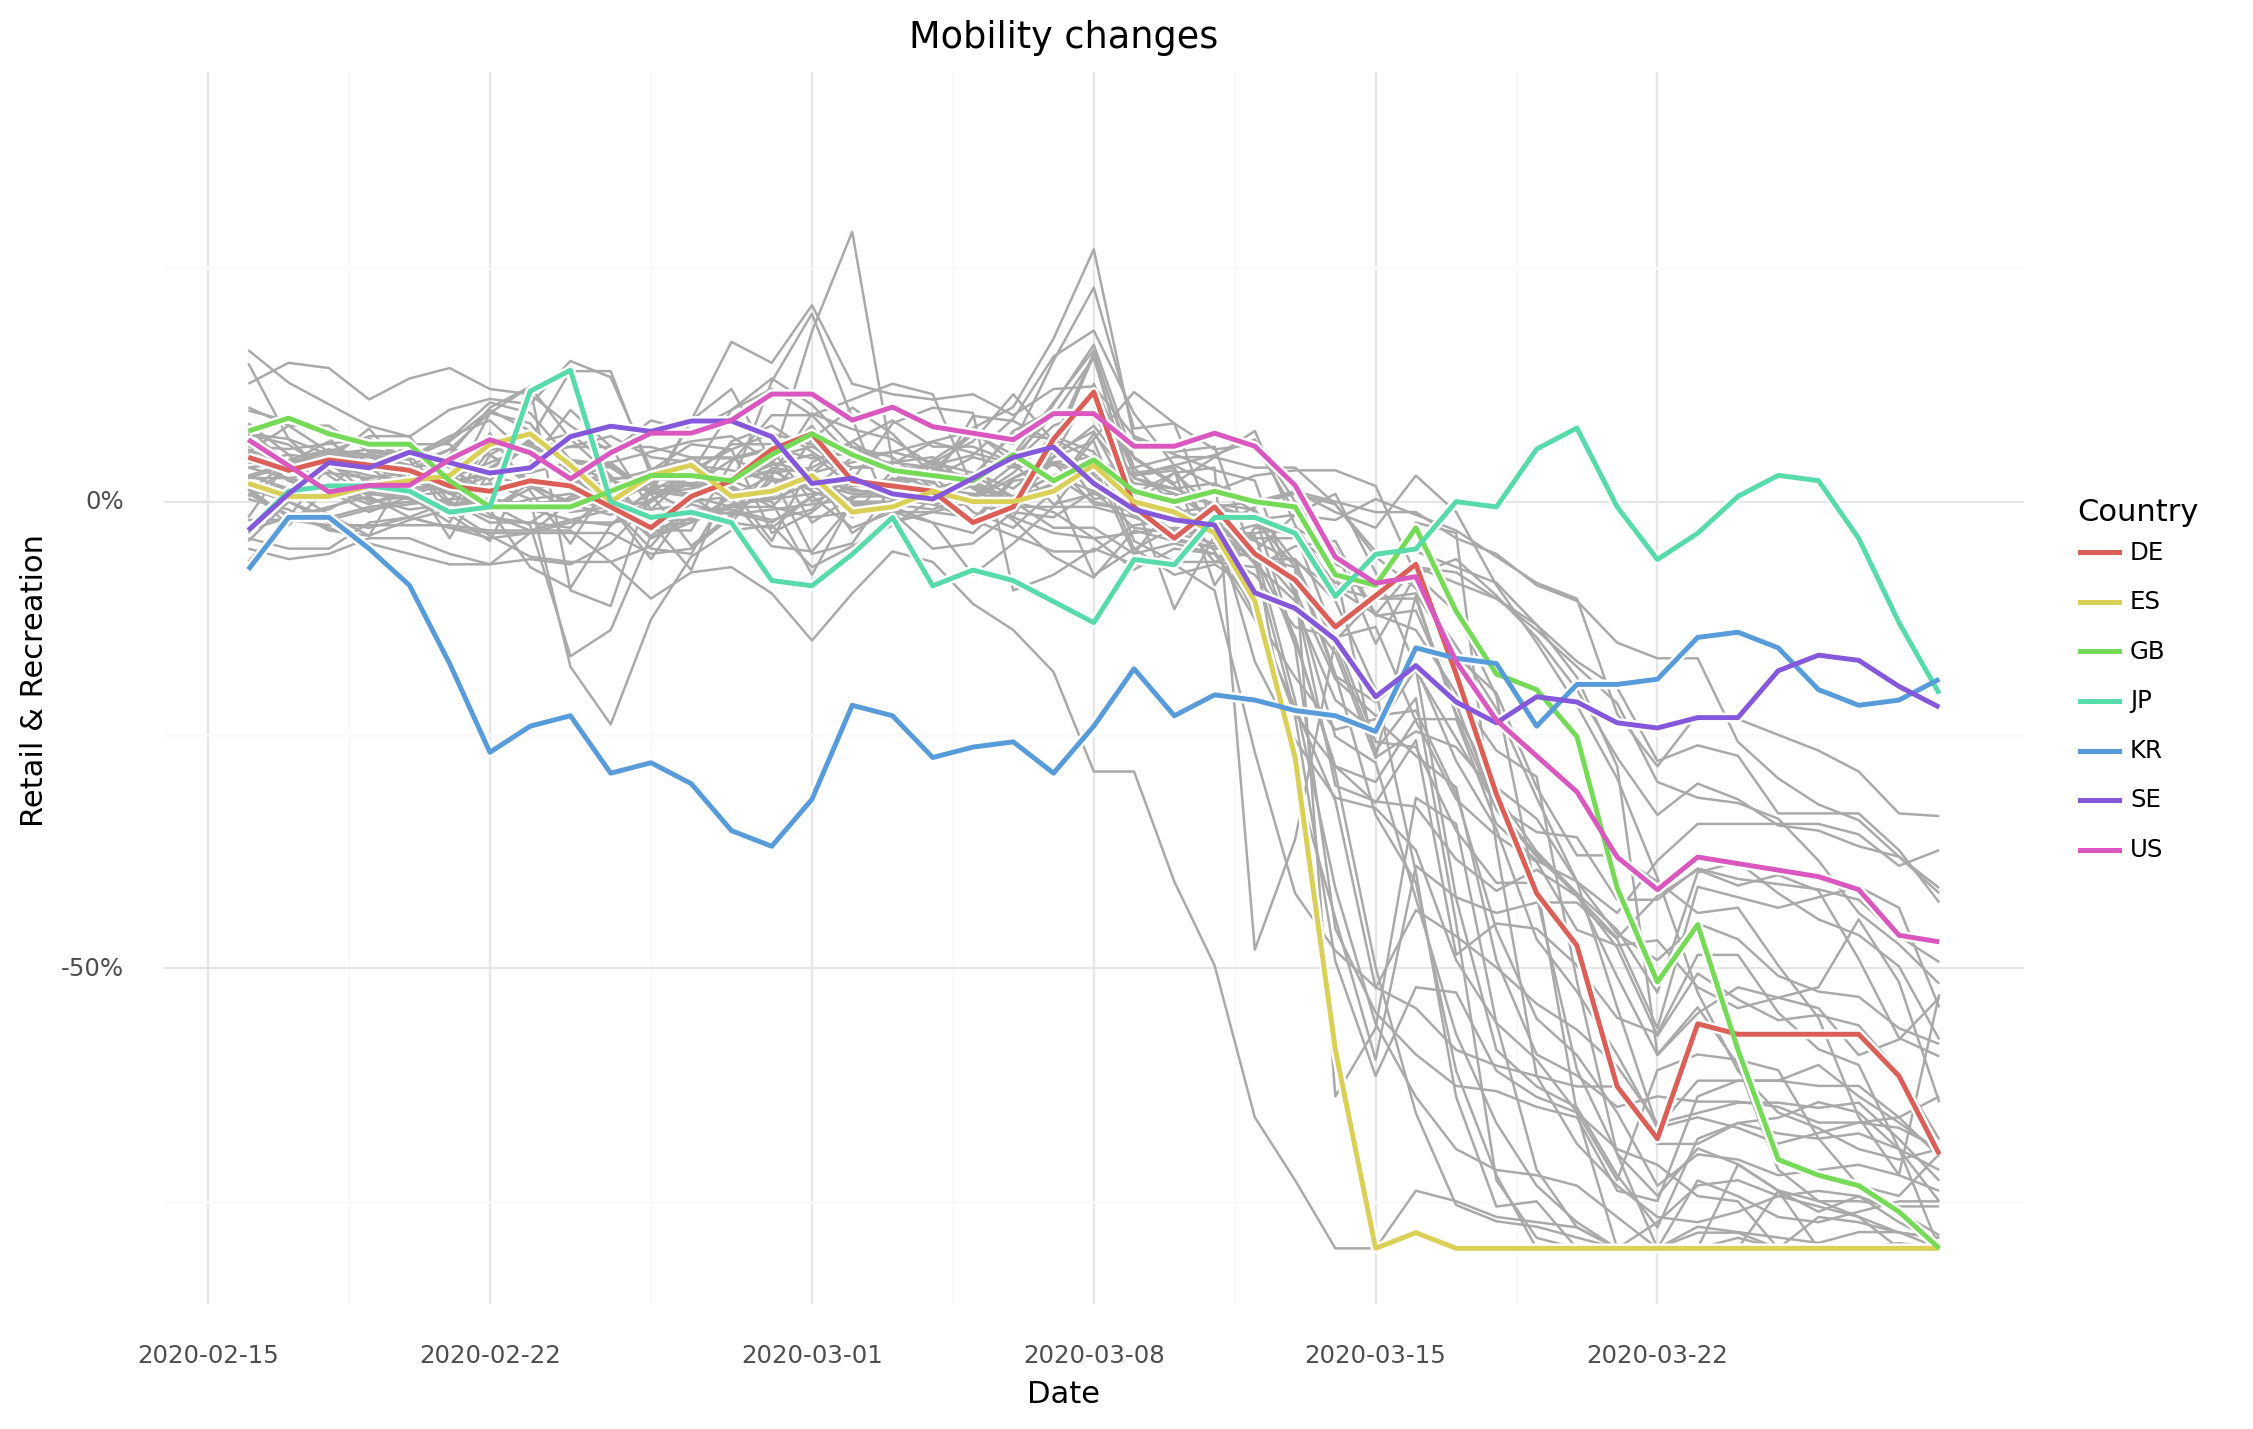

<ggplot: (-9223371871893149932)>

In [37]:
# Pick some countries we want to color in the plot.
select_countries = ['US', 'SE', 'KR', 'GB', 'JP', 'DE', 'ES']

p.options.figure_size = (12, 8)

plot = (
    p.ggplot(
        p.aes(x='date', y='percent_retail_and_recreation', group='country'),
        mobility_df
    )
    + p.geom_line(color='darkgrey')
    + p.geom_line(color='w', data=mobility_df.query('country in @select_countries'), size=2)
    + p.geom_line(p.aes(color='country'), data=mobility_df.query('country in @select_countries'), size=1)
    + p.scale_y_continuous(labels=lambda l: ["%d%%" % (v) for v in l], limits=(-80, 40))
    + p.theme_minimal()
    + p.labs(x='Date', y='Retail & Recreation', title='Mobility changes', color='Country')
)

plot + p.theme(panel_background=p.element_rect(fill='w'))

In [14]:
mobility_df.iloc[-15]

percent_retail_and_recreation                    -80
date                             2020-03-15 00:00:00
country                                           IT
Name: 28, dtype: object

In [15]:
mobility_df['country'].value_counts().shape

(47,)

In [16]:
(
    mobility_df
    .pivot_table(index='date', columns='country', values='percent_retail_and_recreation')
    .iloc[-15]
    .sort_values()
)

country
ES   -80.000000
IT   -80.000000
GR   -61.538462
NO   -59.789474
BE   -56.421053
SI   -55.944056
CZ   -54.736842
MK   -52.125436
LB   -52.027972
AT   -49.855072
FR   -33.566434
IL   -32.842105
IE   -32.280702
EE   -32.112676
DK   -30.035088
LU   -27.972028
NL   -27.412587
HU   -27.412587
EC   -26.666667
AR   -25.734266
KR   -24.615385
CH   -24.615385
IQ   -23.298246
BA   -22.937063
FI   -21.463415
SE   -20.905923
HN   -20.139860
DO   -15.211268
SA   -13.426573
TR   -12.222222
TH   -12.070175
CO   -12.070175
EG   -10.385965
CA   -10.385965
DE   -10.069930
IN    -9.263158
GB    -8.951049
US    -8.733624
MY    -8.391608
CL    -7.578947
BR    -5.894737
JP    -5.633803
ID    -5.333333
PK    -2.797203
AU    -1.118881
BF     0.280702
MX     1.678322
Name: 2020-03-15 00:00:00, dtype: float64

In [17]:
mobility_df['country'].value_counts().sort_index()

AR    43
AT    43
AU    43
BA    43
BE    43
BF    43
BR    43
CA    43
CH    43
CL    43
CO    43
CZ    43
DE    43
DK    43
DO    43
EC    43
EE    43
EG    43
ES    43
FI    43
FR    43
GB    43
GR    43
HN    43
HU    43
ID    43
IE    43
IL    43
IN    43
IQ    43
IT    43
JP    43
KR    43
LB    43
LU    43
MK    43
MX    43
MY    43
NL    43
NO    43
PK    43
SA    43
SE    43
SI    43
TH    43
TR    43
US    43
Name: country, dtype: int64

In [18]:
country_codes = {
    'AR': 'Argentina',
    'AT': 'Austria',
    'AU': 'Australia',
    'BA': 'Bosnia And Herzegovina',
    'BE': 'Belgium',
    'BF': 'Burkina Faso',
    'BR': 'Brazil',
    'CA': 'Canada',
    'CH': 'Switzerland',
    'CL': 'Chile',
    'CO': 'Colombia',
    'CZ': 'Czechia',
    'DE': 'Germany',
    'DK': 'Denmark',
    'DO': 'Dominican Republic',
    'EC': 'Ecuador',
    'EE': 'Estonia',
    'EG': 'Egypt',
    'ES': 'Spain',
    'FI': 'Finland',
    'FR': 'France',
    'GB': 'United Kingdom',
    'GR': 'Greece',
    'HN': 'Honduras',
    'HU': 'Hungary',
    'ID': 'Indonesia',
    'IE': 'Ireland',
    'IL': 'Israel',
    'IN': 'India',
    'IQ': 'Iraq',
    'IT': 'Italy',
    'JP': 'Japan',
    'KR': 'Korea, South',
    'LB': 'Lebanon',
    'LU': 'Luxembourg',
    'MK': 'North Macedonia',
    'MX': 'Mexico',
    'MY': 'Malaysia',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'PK': 'Pakistan',
    'SA': 'Saudi Arabia',
    'SE': 'Sweden',
    'SI': 'Slovenia',
    'TH': 'Thailand',
    'TR': 'Turkey',
    'US': 'US'
}

In [19]:
mobility_df = mobility_df.rename(columns={'country': 'country_code'})

In [20]:
mobility_df['country'] = mobility_df['country_code'].map(country_codes)

In [21]:
mobility_df

,percent_retail_and_recreation,date,country_code,country
0,6.637555,2020-02-16,US,US
1,3.842795,2020-02-17,US,US
2,1.048035,2020-02-18,US,US
3,1.746725,2020-02-19,US,US
4,1.746725,2020-02-20,US,US
...,...,...,...,...
38,-80.000000,2020-03-25,IT,Italy
39,-80.000000,2020-03-26,IT,Italy
40,-80.000000,2020-03-27,IT,Italy
41,-80.000000,2020-03-28,IT,Italy


In [22]:
mobility_df.to_csv('mobility_data.csv')